In [35]:
# 使用sys.path添加上级目录
import sys
import os
package_path = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = os.path.join(package_path, "ch07", "01_main-chapter-code")
print(file_path)
sys.path.append(file_path)

import torch
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

/Users/young/project/llmProject/LLMs-from-scratch-CN/ch07/01_main-chapter-code


In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # 绘图库
    "tiktoken",    # 分词器
    "torch",       # 深度学习库
    "tqdm",        # 进度条
    "tensorflow",  # 用于加载OpenAI的预训练权重
]
for p in pkgs:
    print(f"{p} version: {version(p)}")
# 读取并输出版本号

matplotlib version: 3.9.4
tiktoken version: 0.9.0
torch version: 2.6.0
tqdm version: 4.67.1
tensorflow version: 2.18.0


## 7.2 为有监督微调准备数据集

In [2]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    # else:
    #     with open(file_path, "r", encoding="utf-8") as file:
    #         text_data = file.read()
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    
    return data

In [3]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [4]:
# 查看指令样本
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [5]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [6]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 处理Input为空/非空的情况
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [7]:
# 测试format效果
# Input非空
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [8]:
# 测试format效果
# Input为空
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [11]:
# 数据集划分
# 0.85、0.1、0.05
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [12]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


# 7.3 构建训练数据

In [29]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            # 拼接指令
            instruction_plus_input = format_input(entry)
            # 拼接输出text
            response_text = f"\n\n### Response:\n{entry['output']}"
            # 合并指令+输出
            full_text = instruction_plus_input + response_text
            # 编码上述信息
            self.encoded_texts.append(tokenizer.encode(full_text))
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [15]:
import tiktoken

# 使用gpt2的bpe编码器
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [16]:
# 填充方法
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    # 填充至当前batch的最大长度+1
    # 至少会填充一个<|endoftext|>
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        # 填充endoftext
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        # 去除最后一个token, 作为输入
        # 相对的，如果去掉第一个token，则作为目标
        inputs = torch.tensor(padded[:-1])

        inputs_lst.append(inputs)
    # stack to batch
    inputs_tensor = torch.stack(inputs_lst).to(device)

    return inputs_tensor

In [17]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [18]:
# 增加输入和目标
# 填充方法
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    # 填充至当前batch的最大长度+1
    # 至少会填充一个<|endoftext|>
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        # 填充endoftext
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        # 去除最后一个token, 作为输入
        # 相对的，如果去掉第一个token，则作为目标
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    # stack to batch
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [19]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [21]:
# 增加输入和目标
# 填充方法
def custom_collate_fn(
        batch, 
        pad_token_id=50256, 
        ignore_index=-100,
        allowed_max_length=None,
        device="cpu"
):
    # 填充至当前batch的最大长度+1
    # 至少会填充一个<|endoftext|>
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        # 填充endoftext
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        # 去除最后一个token, 作为输入
        # 相对的，如果去掉第一个token，则作为目标
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # targets中仅保留一个<|endoftext|>，其余填充为ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # 最大长度截断
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    # stack to batch
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [22]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [23]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5]]
)

targets_1 = torch.tensor([0, 1])

loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [24]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)

targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [25]:
# 计算loss时，忽略tokenid = -100的样本
logits_3 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)

targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_3, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


## 7.4 创建指令数据集的数据加载器

In [27]:
from functools import partial
# 将部分参数提前填充，并生成一个新的函数，以适配collate函数的要求
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [50]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [31]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [32]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='mps:0')


In [33]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='mps:0')


## 7.5 加载预训练的大语言模型

In [36]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # 词表大小
    "context_length": 1024,  # 上下文长度
    "drop_rate": 0.0,        # Dropout率
    "qkv_bias": True         # 查询-键-值偏置
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)
model.eval()

/Users/young/project/llmProject/LLMs-from-scratch-CN/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 29.3kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 655kiB/s] 
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 37.3kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [53:21<00:00, 443kiB/s]   
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 3.19MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 484kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 298kiB/s]  


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [37]:
# 查看验证集数据
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [39]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer).to(device),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [40]:
# 提取response
response_text = (
    # 去除输入文本
    generated_text[len(input_text):]
    # 去除无意义的输出
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## 7.6 在指令数据上微调大语言模型

In [41]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

In [51]:
# 查看训练前的loss
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259105682373047
Validation loss: 3.7619349479675295


In [55]:
# 模型训练
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.800, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.809
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.535, Val loss 0.732
Ep 1 (Step 000075): Train loss 0.567, Val loss 0.737
Ep 1 (Step 000080): Train loss 0.602, Val loss 0.731
Ep 1 (Step 000085): Train loss 0.513, Val loss 0.715
Ep 1 (Step 000090): Train loss 0.571, Val loss

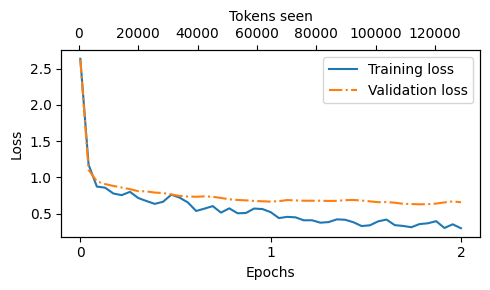

In [56]:
# 绘制损失曲线
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7.7 抽取并保存模型回复

In [57]:
torch.manual_seed(123)

for entry in test_data[:3]:

    # 输入格式化
    input_text = format_input(entry)

    # 生成回答
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    geneerated_text = token_ids_to_text(token_ids, tokenizer)
    # 提取有效回答
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    # 对比output
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> sult is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is:

The result is
-------------------------------------
Below is an instruction that

In [58]:
# 保存测试集的结果
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [02:33<00:00,  1.39s/it]


In [59]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [61]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


## 7.8 评价微调后的大语言模型

In [62]:
# 检测ollama是否正在运行
import psutil 

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Lanunch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [63]:
# 重新加载测试数据
import json
from tqdm import tqdm
# 我们的初始数据集
file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [65]:
# 通过REST api访问ollama
import urllib.request

def query_model(
        prompt,
        model="llama3",
        url="http://localhost:11434/api/chat"
):
    # 构造请求数据
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0.,
            "num_ctx": 2048
        }
    }

    # dict转化json并编码
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # 解析返回结果
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data

model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [66]:
# 使用llama3对模型结果进行打分0-100
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct out `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score."
    )

print("\nDataset response:")
print(">>", entry['output'])
print("\nModel response:")
print(">>", entry["model_response"])
print("\nScore:")
print(">>", query_model(prompt))
print("\n-------------------------")


Dataset response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.

Score:
>> A simple one!

Model response: "The author of 'Pride and Prejudice' is Jane Austen."

Score: 100

Why? Because the model response accurately answers the question by naming the correct author of the novel "Pride and Prejudice", which is indeed Jane Austen. The response matches the instruction perfectly, making it a perfect score!

-------------------------


In [67]:
# 封装上述功能
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []

    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [01:15<00:00,  1.45it/s]

Number of scores: 110 of 110
Average score: 47.79



In [69]:
scores

[85,
 40,
 98,
 60,
 60,
 0,
 20,
 100,
 20,
 40,
 95,
 100,
 20,
 95,
 20,
 40,
 95,
 80,
 85,
 67,
 20,
 20,
 20,
 60,
 20,
 60,
 80,
 40,
 95,
 20,
 98,
 80,
 40,
 44,
 98,
 20,
 100,
 95,
 100,
 20,
 85,
 100,
 20,
 60,
 60,
 92,
 20,
 4,
 95,
 67,
 40,
 90,
 20,
 20,
 20,
 60,
 20,
 0,
 85,
 80,
 95,
 20,
 20,
 5,
 60,
 40,
 60,
 80,
 20,
 20,
 20,
 20,
 4,
 90,
 0,
 20,
 20,
 92,
 20,
 100,
 95,
 20,
 4,
 20,
 60,
 20,
 20,
 20,
 40,
 20,
 20,
 85,
 66,
 20,
 20,
 0,
 40,
 95,
 4,
 85,
 85,
 20,
 4,
 20,
 20,
 20,
 20,
 80,
 20,
 20]